## Building Fake News Classifer with DistilBERT, T5

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

Link to dataset: https://www.kaggle.com/datasets/sonalgarg174/ifnd-dataset

In [2]:
df = pd.read_csv('IFND dataset/IFND.csv',encoding = "ISO-8859-1")
df

,id,Statement,Image,Web,Category,Date,Label
0,2,"WHO praises India's Aarogya Setu app, says it ...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
1,3,"In Delhi, Deputy US Secretary of State Stephen...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,VIOLENCE,Oct-20,TRUE
2,4,LAC tensions: China's strategy behind delibera...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,TERROR,Oct-20,TRUE
3,5,India has signed 250 documents on Space cooper...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
4,6,Tamil Nadu chief minister's mother passes away...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,ELECTION,Oct-20,TRUE
...,...,...,...,...,...,...,...
56709,56711,Fact Check: This is not Bruce Lee playing ping...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,MISLEADING,11-2019,Fake
56710,56712,Fact Check: Did Japan construct this bridge in...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,COVID-19,10-2019,Fake
56711,56713,Fact Check: Viral video of Mexico earthquake i...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,MISLEADING,10-2019,Fake
56712,56714,Fact Check: Ballet performance by Chinese coup...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,COVID-19,9-2019,Fake


***EDA***

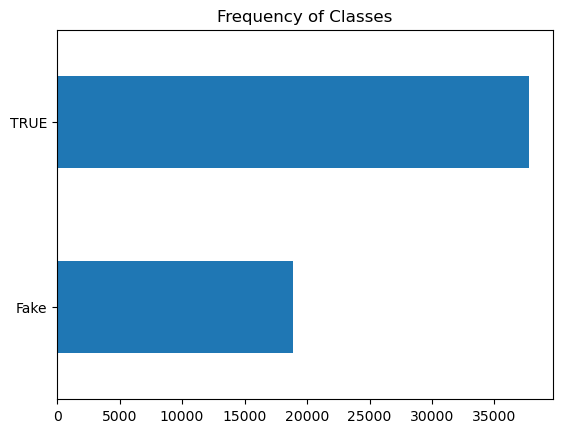

In [3]:
df["Label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

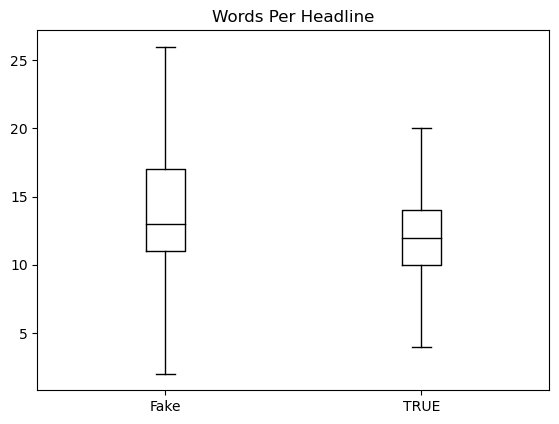

In [4]:
df["Words Per Headline"] = df["Statement"].str.split().apply(len)
df.boxplot("Words Per Headline", by="Label", grid=False,
 showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

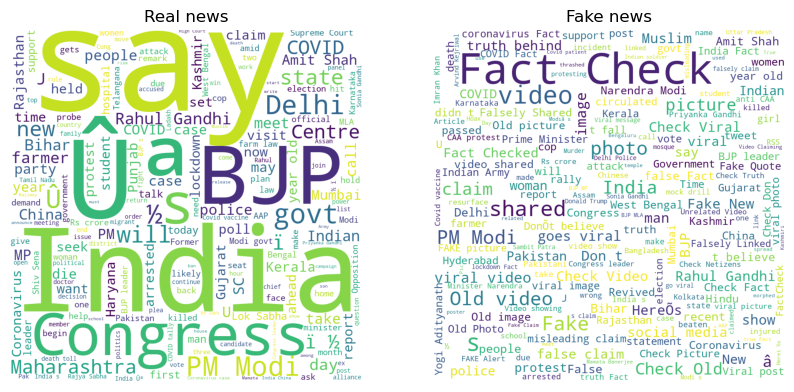

In [5]:
from wordcloud import WordCloud

wordcloud_positive = WordCloud(width=800, height=800, background_color='white').generate(" ".join(df[df['Label'] == 'TRUE']['Statement']))
wordcloud_negative = WordCloud(width=800, height=800, background_color='white').generate(" ".join(df[df['Label'] == 'Fake']['Statement']))

# plot word clouds
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(wordcloud_positive)
axes[0].set_title('Real news')
axes[0].axis('off')
axes[1].imshow(wordcloud_negative)
axes[1].set_title('Fake news')
axes[1].axis('off')
plt.show()

### Pre-processing

Dropping unnecessary columns as we will only focus on the text in this case

In [6]:
df = df.drop(['Image','Web','Date','Category','id'],axis=1)

In [7]:
df = df.rename(columns={'Label': 'label_name'})

***Adding binary row for labels***

In [8]:
y = pd.get_dummies(df['label_name'])
y = y.iloc[:,0].values
df['label']=y

In [9]:
df

,Statement,label_name,Words Per Headline,label
0,"WHO praises India's Aarogya Setu app, says it ...",TRUE,13,0
1,"In Delhi, Deputy US Secretary of State Stephen...",TRUE,13,0
2,LAC tensions: China's strategy behind delibera...,TRUE,10,0
3,India has signed 250 documents on Space cooper...,TRUE,13,0
4,Tamil Nadu chief minister's mother passes away...,TRUE,9,0
...,...,...,...,...
56709,Fact Check: This is not Bruce Lee playing ping...,Fake,11,1
56710,Fact Check: Did Japan construct this bridge in...,Fake,10,1
56711,Fact Check: Viral video of Mexico earthquake i...,Fake,11,1
56712,Fact Check: Ballet performance by Chinese coup...,Fake,12,1


**Note:** We can see from the **word cloud** that for many fake news headlines there is a common prefix **"Fact Check"** attached to it and the original headline also seems to be altered with **negative and skeptical words** like "not", "did", etc.<br>
Lets verify this observation

In [10]:
df.label_name.value_counts()

TRUE    37800
Fake    18914
Name: label_name, dtype: int64

In [11]:
count = df['Statement'].str.count('Fact Check')
count.sum()

9362

In [12]:
from collections import Counter

# filter DataFrame by category of interest
df_filtered = df[df['label'] == 1]

# join all text in the filtered DataFrame
text_joined = ' '.join(df_filtered['Statement'])

# split the joined text into words
words = text_joined.split()

# count the occurrence of each word
word_counts = Counter(words)

# get the 5 most common words
word_counts.most_common(25)

[('Check:', 8620),
 ('Fact', 8050),
 ('of', 6295),
 ('in', 5016),
 ('not', 3577),
 ('the', 3516),
 ('is', 3457),
 ('to', 3180),
 ('a', 2942),
 ('video', 2312),
 ('Of', 2169),
 ('as', 2137),
 ('No,', 2119),
 ('this', 2067),
 ('Did', 1936),
 ('from', 1929),
 ('on', 1922),
 ('Video', 1799),
 ('for', 1573),
 ('In', 1487),
 ('viral', 1474),
 ('with', 1473),
 ('This', 1427),
 ('Old', 1399),
 ('To', 1256)]

In [13]:
words_removed = ['Fact Check','truth behind','fact checked','Falsely','False','FAKE',' not ','don t','Alert','FactCheck','misleading','never','wrong','unrelated','old ',' no ',' did ', ' t ', ' s ',' , ',': '] 

In [14]:
pattern = '|'.join(map(re.escape, words_removed))
df.loc[df['label']==1, 'Statement'] = df.loc[df['label']==1, 'Statement'].str.replace(pattern, '',flags=re.IGNORECASE)

C:\Users\Rajat\AppData\Local\Temp\ipykernel_18292\10951577.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[df['label']==1, 'Statement'] = df.loc[df['label']==1, 'Statement'].str.replace(pattern, '',flags=re.IGNORECASE)


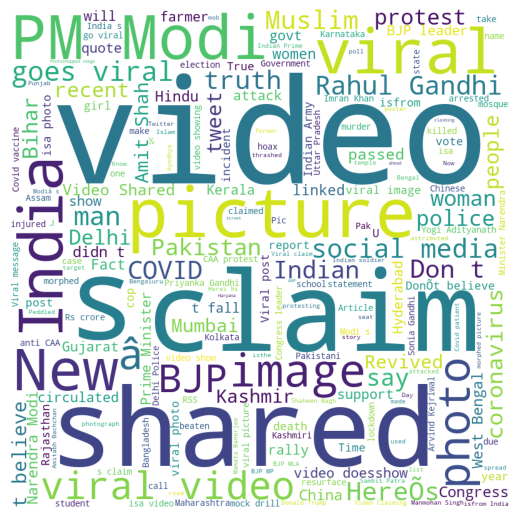

In [15]:
wordcloud_negative = WordCloud(width=800, height=800, background_color='white').generate(" ".join(df[df['label'] == 1]['Statement']))

plt.figure(figsize=(5,5))
plt.imshow(wordcloud_negative)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [16]:
df[df['label'] == 1]

,Statement,label_name,Words Per Headline,label
37800,1938 video of BKS Iyengar shared as PM Modi p...,Fake,13,1
37801,Conspiracy theory claims Sushant was killed f...,Fake,13,1
37802,Gujarats Rani ki Vav shared as palace built ...,Fake,15,1
37803,"No, PM Modi hasannounced another Covid-19 loc...",Fake,11,1
37804,The curious case of a 'desecrated' Kali idol ...,Fake,14,1
...,...,...,...,...
56709,This isBruce Lee playing ping-pong with Nunchaku,Fake,11,1
56710,Did Japan construct this bridge in 24 hours?,Fake,10,1
56711,Viral video of Mexico earthquake is 2 years old,Fake,11,1
56712,Ballet performance by Chinese couple goes vira...,Fake,12,1


### Pre-processing using Hugging Face Tokennizer

In [8]:
from datasets import Dataset

In [9]:
dataset = Dataset.from_pandas(df)

In [10]:
dataset

Dataset({
    features: ['Statement', 'label_name', 'label'],
    num_rows: 56714
})

In [11]:
dataset.features

{'Statement': Value(dtype='string', id=None),
 'label_name': Value(dtype='string', id=None),
 'label': Value(dtype='uint8', id=None)}

In [12]:
dataset = dataset.shuffle()

In [13]:
train_test_split = dataset.train_test_split(test_size=0.20)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Further split the train dataset into train and validation
train_val_split = train_dataset.train_test_split(test_size=0.25)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

In [14]:
from datasets import DatasetDict

dataset_dict = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})

In [15]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['Statement', 'label_name', 'label'],
        num_rows: 34028
    })
    validation: Dataset({
        features: ['Statement', 'label_name', 'label'],
        num_rows: 11343
    })
    test: Dataset({
        features: ['Statement', 'label_name', 'label'],
        num_rows: 11343
    })
})

In [16]:
trainds = dataset_dict["train"]

### Using DistilBERT

In [17]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [18]:
def tokenize(batch):
 return tokenizer(batch["Statement"], padding=True, truncation=True)

In [20]:
print(tokenize(dataset_dict["train"][:2]))

{'input_ids': [[101, 14065, 2891, 14841, 6824, 7911, 3379, 22707, 2158, 11774, 3709, 2011, 3017, 2610, 1029, 2755, 4638, 102, 0, 0, 0, 0, 0, 0, 0], [101, 2192, 2058, 4230, 1997, 2522, 17258, 1011, 2539, 13172, 2000, 2945, 2302, 3403, 2005, 3231, 3189, 1010, 26445, 2102, 7890, 4449, 6768, 22410, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [21]:
dataset_encoded = dataset_dict.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/34028 [00:00<?, ? examples/s]

Map:   0%|          | 0/11343 [00:00<?, ? examples/s]

Map:   0%|          | 0/11343 [00:00<?, ? examples/s]

In [22]:
print(dataset_encoded["train"].column_names)

['Statement', 'label_name', 'label', 'input_ids', 'attention_mask']


In [23]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Fine-tuning model

In [25]:
!nvidia-smi

Mon Apr 10 11:44:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.34       Driver Version: 457.34       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8     4W /  N/A |    378MiB /  4096MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
from transformers import AutoModelForSequenceClassification
num_labels = 2
model = (AutoModelForSequenceClassification
 .from_pretrained(model_ckpt, num_labels=num_labels)
 .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

In [27]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
 labels = pred.label_ids
 preds = pred.predictions.argmax(-1)
 f1 = f1_score(labels, preds, average="weighted")
 acc = accuracy_score(labels, preds)
 return {"accuracy": acc, "f1": f1}

In [28]:
from transformers import Trainer, TrainingArguments
batch_size = 16
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs= 2,
                                  learning_rate= 2e-5,
                                  per_device_train_batch_size= batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [29]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["validation"], 
                  tokenizer=tokenizer)

trainer.train();

C:\Users\Rajat\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Currently logged in as: rajdhanu0302. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.130700,0.108734,0.970643,0.970461
2,0.074600,0.122939,0.970114,0.970001


In [26]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["validation"], 
                  tokenizer=tokenizer)

trainer.train();

C:\Users\Rajat\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.143800,0.125344,0.969761,0.969576
2,0.086100,0.124512,0.970643,0.970497
3,0.052900,0.154212,0.970731,0.970637


***Visualising outputs***

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

***Error Analysis***

In [ ]:
from torch.nn.functional import cross_entropy

In [ ]:
def forward_pass_with_label(batch):
 # Place all input tensors on the same device as the model
 inputs = {k:v.to(device) for k,v in batch.items()
           if k in tokenizer.model_input_names}
 with torch.no_grad():
 output = model(**inputs)
 pred_label = torch.argmax(output.logits, axis=-1)
 loss = cross_entropy(output.logits, batch["label"].to(device),
 reduction="none")
 # Place outputs on CPU for compatibility with other dataset columns
 return {"loss": loss.cpu().numpy(),
 "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
 columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
 forward_pass_with_label, batched=True, batch_size=16)

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
 .apply(label_int2str))

In [ ]:
#data samples with the highest losses
df_test.sort_values("loss", ascending=False).head(10)

In [ ]:
# data samples with the smallest losses
df_test.sort_values("loss", ascending=True).head(10)

***Saving and sharing model***

In [ ]:
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "rajatdhanuka/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_headline = "Ranveer Singh spotted outside his gym wearing his favourite skirt"
preds = classifier(custom_tweet, return_all_scores=True)

In [9]:
from simpletransformers.t5 import T5Model

***Pre-processing***

In [10]:
X = df.drop(['label_name'],axis=1)

In [11]:
X = X.rename(columns={'Statement': 'input_text','label':'target_text'})

In [12]:
X['target_text'] = X['target_text'].astype(str)

In [13]:
X['prefix'] = ['binary classifiction']*56714

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size=0.20, random_state=0)

***Training***

In [27]:
model_args = {
    "max_seq_length": 196,
    "train_batch_size": 16,
    "eval_batch_size": 1,
    "num_train_epochs": 1,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 15000,
    "evaluate_during_training_verbose": True,
    "use_multiprocessing": False,
    "fp16": False,
    "save_steps": -1,
    "save_eval_checkpoints": False,
    "save_model_every_epoch": False,
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "wandb_project": "T5 mixed tasks - Binary, Multi-Label, Regression",
}

In [28]:
model = T5Model("t5", "t5-small", args=model_args)

In [29]:
torch.cuda.empty_cache()
#torch.cuda.memory_allocated(3 * 1024 * 1024 * 1024)  # set to 3GB
#torch.cuda.memory_reserved(3 * 1024 * 1024 * 1024)
#torch.cuda.set_per_process_memory_fraction(0.8)

In [30]:
model.train_model(X_train, eval_data=X_test)

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 4.00 GiB total capacity; 2.47 GiB already allocated; 8.64 MiB free; 2.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

***Testing***

In [ ]:
import json
from datetime import datetime
from pprint import pprint
from statistics import mean

from scipy.stats import pearsonr, spearmanr
from transformers.data.metrics.squad_metrics import compute_exact, compute_f1

def f1(truths, preds):
    return mean([compute_f1(truth, pred) for truth, pred in zip(truths, preds)])

def exact(truths, preds):
    return mean([compute_exact(truth, pred) for truth, pred in zip(truths, preds)])

def pearson_corr(preds, labels):
    return pearsonr(preds, labels)[0]

def spearman_corr(preds, labels):
    return spearmanr(preds, labels)[0]

model_args = {
    "overwrite_output_dir": True,
    "max_seq_length": 196,
    "eval_batch_size": 16,
    "use_multiprocessing": False,
    "num_beams": None,
    "do_sample": True,
    "max_length": 50,
    "top_k": 50,
    "top_p": 0.95,
    "num_return_sequences": 3,
}

# Load the trained model
model = T5Model("outputs", args=model_args)

# Prepare the data for testing
to_predict = [
    prefix + ": " + str(input_text)
    for prefix, input_text in zip(X_train["prefix"].tolist(), X_train["input_text"].tolist())
]
truth = X_train["target_text"].tolist()
tasks = X_train["prefix"].tolist()

# Get the model predictions
preds = model.predict(to_predict)

# Saving the predictions if needed
with open(f"predictions/predictions_{datetime.now()}.txt", "w") as f:
    for i, text in enumerate(X_train["input_text"].tolist()):
        f.write(str(text) + "\n\n")

        f.write("Truth:\n")
        f.write(truth[i] + "\n\n")

        f.write("Prediction:\n")
        for pred in preds[i]:
            f.write(str(pred) + "\n")
        f.write(
            "________________________________________________________________________________\n"
        )

# Taking only the first prediction
preds = [pred[0] for pred in preds]
X_train["predicted"] = preds

# Evaluating the tasks separately
output_dict = {
    "binary classification": {
        "truth": [],
        "preds": [],
    }
}

results_dict = {}

for task, truth_value, pred in zip(tasks, truth, preds):
    output_dict[task]["truth"].append(truth_value)
    output_dict[task]["preds"].append(pred)

print("-----------------------------------")
print("Results: ")
for task, outputs in output_dict.items():
    if task == "multilabel classification":
        try:
            task_truth = output_dict[task]["truth"]
            task_preds = output_dict[task]["preds"]
            results_dict[task] = {
                "F1 Score": f1(task_truth, task_preds),
                "Exact matches": exact(task_truth, task_preds),
            }
            print(f"Scores for {task}:")
            print(f"F1 score: {f1(task_truth, task_preds)}")
            print(f"Exact matches: {exact(task_truth, task_preds)}")
            print()
        except:
            pass
    elif task == "binary classification":
        try:
            task_truth = [int(t) for t in output_dict[task]["truth"]]
            task_preds = [int(p) for p in output_dict[task]["preds"]]
            results_dict[task] = {
                "F1 Score": f1_score(task_truth, task_preds),
                "Accuracy Score": accuracy_score(task_truth, task_preds),
            }
            print(f"Scores for {task}:")
            print(f"F1 score: {results_dict[task]['F1 Score']}")
            print(f"Accuracy Score: {results_dict[task]['Accuracy Score']}")
            print()
        except:
            pass
    if task == "similarity":
        task_truth = [float(t) for t in output_dict[task]["truth"]]
        task_preds = [float(p) for p in output_dict[task]["preds"]]
        results_dict[task] = {
            "Pearson Correlation": pearson_corr(task_truth, task_preds),
            "Spearman Correlation": spearman_corr(task_truth, task_preds),
        }
        print(f"Scores for {task}:")
        print(f"Pearson Correlation: {results_dict[task]['Pearson Correlation']}")
        print(f"Spearman Correlation: {results_dict[task]['Spearman Correlation']}")
        print()

with open(f"results/result_{datetime.now()}.json", "w") as f:
    json.dump(results_dict, f)

In [19]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
#nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

In [20]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [21]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)
    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}

  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]

  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [22]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [23]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [24]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

C:\Users\Rajat\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Rajat\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\Rajat\anaconda3\lib\site-packages\transformers\models\t5\tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [25]:
def tokenize(batch):
 return tokenizer(batch["Statement"], padding=True, truncation=True)

In [ ]:
print(tokenize(dataset_dict["train"][:2]))

{'input_ids': [[3, 2326, 10319, 7, 14840, 71, 2965, 6098, 322, 2067, 9288, 13674, 7, 9, 77, 365, 3246, 4569, 1], [18263, 31251, 22660, 6323, 325, 226, 348, 16738, 67, 7, 44, 3, 3840, 1, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]}


In [27]:
dataset_encoded = dataset_dict.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/34028 [00:00<?, ? examples/s]

Map:   0%|          | 0/11343 [00:00<?, ? examples/s]

Map:   0%|          | 0/11343 [00:00<?, ? examples/s]

In [29]:
args_dict.update({'data_dir': 'IFND', 'output_dir': 't5_ifnd_fake_news', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm
)

In [30]:
model = T5FineTuner(args)

AttributeError: can't set attribute 'hparams'